## stacking 集成算法：次级学习器融合-常规模型
- 1.LassoCV
- 2.RidgeCV
- 3.ElasticNetCV

In [1]:
# 导入必要的工具包
import numpy as np #用于数值计算
import pandas as pd #用于数据表处理，数据文件读写
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV

import matplotlib.pyplot as plt #用于绘图：分析结果的可视化。
%matplotlib inline

In [2]:
def get_train_val(val_id):
    '''获取训练集和校验集 
    val_id = 0,1,2 #当前校验集编号 '''
    print('val_id=%s'% (val_id))
    df_val = train_list[val_id]
    train_tmp = []

    for i in range(1, train_part_num):
        cur_id = (val_id + i) % 5
        print('cur_id=%s'% (cur_id))
        train_tmp.append(train_list[cur_id])
    
#     只生成一次，节省内存 
    df_train = pd.concat(train_tmp)
    print('df_train.shape=%s  df_val.shape=%s'% (df_train.shape, df_val.shape))
    return df_train, df_val

In [3]:
Y_Standard = True
path_train = '../data/new/train=predict/'
path_test = '../data/new/test=predict/'

val_path = '../data/val/second/' #保存校验集测试结果
val_name = '%sval=stacking-%s-%s.csv'
summit_path = '../data/summit/stacking-second/' #保存提交文件，测试集测试结果 
out_name = '%ssummit=stacking-%s-%s.csv' # 生成的结果文件名称
base = 'second' #学习器级别 

train_part_num = 5 #训练集拆分个数
target = 'prediction_pay_price'
user_id = 'user_id'

## 指定读取数据类型，节省内存

In [4]:
col_int32 = ['user_id']
col_float32 = ['pred_0', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7']

In [5]:
# 指定读取数据类型，节省内存
dtype_test = {}
for col in col_int32:
    dtype_test[col] = np.int32
for col in col_float32:
    dtype_test[col] = np.float32
# dtype_test

In [6]:
dtype_train = dtype_test.copy()
dtype_train[target] = np.float32
# dtype_train

## 读取数据，一次读取多次使用，不同组合 

In [7]:
train_list = []
for i in range(train_part_num):
    cur_id = i + 1
    train_list.append(pd.read_csv('%strain=pred-1-col=9-target-%s.csv' % (path_train, cur_id), dtype=dtype_train))
train_list[0].head()

,user_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,prediction_pay_price
0,332994,0.0000,0.0001,0.0000,0.3495,0.0001,0.0000,0.0000,0.0001,0.0000
1,2186887,0.1648,0.0001,0.0000,0.3495,0.0046,0.0000,0.1085,0.0002,0.0000
2,383991,0.1635,0.0001,0.0000,0.3495,0.0001,0.0000,0.0527,0.0001,0.0000
3,102315,0.1576,0.0001,0.0000,0.3495,0.0002,0.0000,0.0576,0.0001,0.0000
4,225310,0.0000,0.0001,0.0000,0.3495,0.0007,0.0000,0.0131,0.0001,0.0000


## 5折交叉验证

In [8]:
# 根据校验集编号 0，1,2,3,4 ，获取训练集和校验集
df_train, df_val = get_train_val(4)

# 从原始数据中分离输入特征x和输出y
train_y = df_train[target].values
train_X = df_train.drop([target, user_id], axis = 1)
val_y = df_val[target].values
val_X = df_val.drop([target, user_id], axis = 1)

val_id=4
cur_id=0
cur_id=1
cur_id=2
cur_id=3
df_train.shape=(1830405, 10)  df_val.shape=(457602, 10)


In [9]:
# 数据标准化：分别初始化对特征和目标值的标准化器 
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
train_X_ss = ss_X.fit_transform(train_X)
val_X_ss = ss_X.transform(val_X)

if Y_Standard:
    train_y_ss = ss_y.fit_transform(train_y.reshape(-1, 1))
    val_y_ss = ss_y.transform(val_y.reshape(-1, 1))

# 需要转换为一维数组 
train_y_ss_1d = train_y_ss.reshape(train_y_ss.shape[0])
val_y_ss_1d = val_y_ss.reshape(val_y_ss.shape[0])

In [10]:
def inverse_StandardScaler(predict):
    ''' 标准化数据还原  '''
    if Y_Standard:
        predict = ss_y.inverse_transform(predict)
        print('predict = ', predict)
    return predict

def generate_summit(predict):
    ''' 输出预测后的数据 '''
    testPredict = test.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

def generate_val_predict(predict):
    ''' 生成校验集预测后的数据 '''
    testPredict = df_val.copy()
    testPredict[target] = predict
    testPredict = testPredict[[user_id, target]]
#     应该过滤掉负数
    testPredict[target] = testPredict[target].apply(lambda x: x if x > 0 else 0)
    return testPredict

## 模型训练
### 1.正则化的线性回归（L1正则 --> Lasso）

In [11]:
%%time
# alphas = [0.1, 10, 100, 1000, 10000]
alphas = [0.001,0.01,0.1]

lasso = LassoCV(alphas=alphas)
lasso.fit(train_X_ss, train_y_ss_1d)
print ('best_alpha=', lasso.alpha_)

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best_alpha= 0.01
Wall time: 30.2 s


best alpha is: 0.01


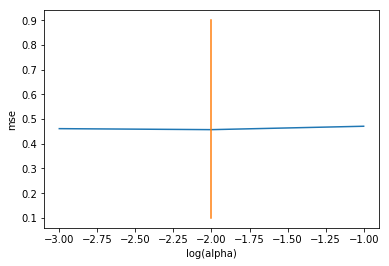

In [12]:
## 3.1 Lasso 模型评价
mses = np.mean(lasso.mse_path_, axis=1)

#plt.plot(np.log10(alphas), mses)
plt.plot(np.log10(lasso.alphas_), mses)
# plt.show()  #绘制在一张图上，显示异常，暂时分开 

plt.plot(np.log10(lasso.alpha_)*np.ones(3), [0.1, 0.5, 0.9])
plt.xlabel('log(alpha)')
plt.ylabel('mse')
# plt.show() 
print ('best alpha is:', lasso.alpha_)
# best alpha is: 10.5

In [13]:
# 模型评估
lassoScoreTrain = lasso.score(train_X_ss, train_y_ss)
lassoScoreVal = lasso.score(val_X_ss, val_y_ss)
print('The score: Train=%s  Val=%s'% (lassoScoreTrain, lassoScoreVal)) 

lasso_predict_train = lasso.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss, lasso_predict_train) ** 0.5
lasso_predict_val = lasso.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss, lasso_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score: Train=0.6026498641616385  Val=0.8354317552131078
# The RMSE: Train=0.6303571494306712  Val=0.5921995943739873

The score: Train=0.5527422257275408  Val=0.4433311826261124
The RMSE: Train=0.6687734684827882  Val=0.6564895541349325


### 保存校验集测试结果

In [14]:
print('lasso_predict_val= ', lasso_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(lasso_predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'lasso'), index=False)
valPredict.head()

lasso_predict_val=  [-0.02334918 -0.02385629 -0.02334918 ... -0.01392015 -0.02336521
 -0.0234022 ]
predict =  [-0.2885168  -0.33442581 -0.2885168  ...  0.56510002 -0.28996789
 -0.2933163 ]


,user_id,prediction_pay_price
0,1987367,0.0000
1,2292622,0.0000
2,466954,0.0000
3,1008130,0.0000
4,9759,0.0000


## 加载测试数据

In [15]:
test = pd.read_csv(path_test + 'test=pred-1-col=9.csv', dtype=dtype_test)
test_X = test.drop([user_id], axis = 1)
test_X_ss = ss_X.transform(test_X)
test.head()

,user_id,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7
0,14933,0.0842,0.0002,0.0079,0.4069,0.0001,0.0102,1.6502,0.0002
1,14934,0.0592,0.0001,0.0000,0.4069,0.0000,0.0000,0.6719,0.0001
2,14935,0.3927,0.0001,0.0000,0.4069,0.0000,0.0000,0.9312,0.0001
3,14936,1.5131,0.0063,0.2355,0.4069,0.0000,0.2351,1.3646,0.0001
4,14937,0.0000,0.0001,0.0000,0.4069,0.0000,0.0000,0.5996,0.0001


In [16]:
#对测试数据进行预测
lasso_y_predict_test = lasso.predict(test_X_ss)
print('lasso_y_predict_test = ', lasso_y_predict_test)

# 标准化数据还原 
lasso_y_predict_test = inverse_StandardScaler(lasso_y_predict_test)
# lasso_y_predict_test =  [0.4556051 0.4556051 0.4556051 ... 0.4556051 0.4556051 0.4556051]

lasso_y_predict_test =  [-0.02342441 -0.02349682 -0.02432829 ... -0.02383239 -0.02408796
 -0.02454619]
predict =  [-0.29532704 -0.30188254 -0.37715624 ... -0.33226201 -0.35539935
 -0.39688259]


In [17]:
testPredict = generate_summit(lasso_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'lasso'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000


## 2 正则化的线性回归（L2正则 --> 岭回归）

In [18]:
%%time
#正则项的参数
# alphas = [0.1, 1, 10, 100, 10000]
alphas = [0.1, 7000,9000,10000,11000,13000, 20000, 100000]
ridge = RidgeCV(alphas=alphas, store_cv_values=True)
ridge.fit(train_X_ss, train_y_ss_1d)
print('best alpha is:', ridge.alpha_)

best alpha is: 20000.0
Wall time: 3.19 s


best alpha is: 20000.0


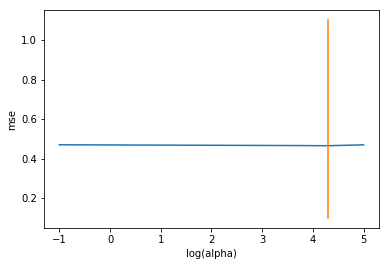

In [19]:
### 2.1 岭回归模型评价
mse_mean = np.mean(ridge.cv_values_, axis=0)

#正则项参数取对数， mse_mean.reshape() 干什么的？拉平
plt.plot(np.log10(alphas), mse_mean.reshape(len(alphas), 1))
# 在最佳参数位置绘制竖线：注意第二个参数值要和 Y 坐标轴匹配
plt.plot(np.log10(ridge.alpha_)*np.ones(3), [.1, .5, 1.1])
# plt.show() #绘制在一张图上，显示异常，暂时分开 

plt.xlabel('log(alpha)')
plt.ylabel('mse')
print('best alpha is:', ridge.alpha_)

In [20]:
# 模型评估
ridgeScoreTrain = ridge.score(train_X_ss, train_y_ss_1d)
ridgeScoreVal = ridge.score(val_X_ss, val_y_ss_1d)
print('The score: Train=%s  Val=%s'% (ridgeScoreTrain, ridgeScoreVal)) 

ridge_predict_train = ridge.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, ridge_predict_train) ** 0.5
ridge_predict_val = ridge.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, ridge_predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score: Train=0.6886471998505836  Val=0.5049070896778365
# The RMSE: Train=0.5579899841294994  Val=0.8149389859862378

The score: Train=0.5577511067779233  Val=0.44013286572283833
The RMSE: Train=0.6650180968245065  Val=0.6583727693664453


### 保存校验集测试结果

In [21]:
print('ridge_predict_val= ', ridge_predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(ridge_predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'RidgeCV'), index=False)
valPredict.head()

ridge_predict_val=  [-0.02060937 -0.02335947 -0.02237336 ... -0.01187386 -0.02241684
 -0.0224852 ]
predict =  [-0.0404802  -0.28944815 -0.20017549 ...  0.7503521  -0.20411168
 -0.21029972]


,user_id,prediction_pay_price
0,1987367,0.0000
1,2292622,0.0000
2,466954,0.0000
3,1008130,0.0000
4,9759,0.0000


In [22]:
#对测试数据进行预测
ridge_y_predict_test = ridge.predict(test_X_ss)
print('ridge_y_predict_test = ', ridge_y_predict_test)

# 标准化数据还原 
ridge_y_predict_test = inverse_StandardScaler(ridge_y_predict_test)

ridge_y_predict_test =  [-0.02231382 -0.02253933 -0.02406533 ... -0.0221977  -0.02374308
 -0.02458729]
predict =  [-0.1947846  -0.21520041 -0.35335043 ... -0.18427235 -0.32417682
 -0.40060384]


In [23]:
# ridge_y_predict_test = move_up(ridge_y_predict_test)
#输出预测后的数据
testPredict = generate_summit(ridge_y_predict_test)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'RidgeCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000


### 3. 正则化的线性回归 ElasticNetCV 

In [24]:
%%time
# l1_ratio = [.1, .5, .7, .9, .95, .99, 1]
l1_ratio = [.99, 1]

model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.001) #效果最好
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.005)
# model = ElasticNetCV(l1_ratio=l1_ratio, eps=0.0005)
model.fit(train_X_ss, train_y_ss_1d)
print ('best alpha is:%s  l1_ratio_:%s' % (model.alpha_, model.l1_ratio_))
# best alpha is:0.023491824547378765  l1_ratio_:1.0
# Wall time: 1min 17s

best alpha is:0.006051722270061024  l1_ratio_:0.99
Wall time: 43.6 s


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best alpha is:0.006051722270061024  l1_ratio_:0.99


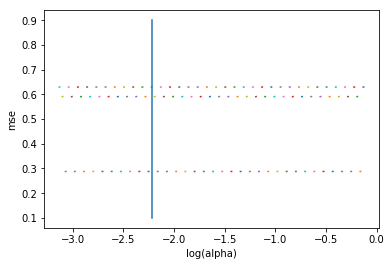

In [25]:
## 3.1 Lasso 模型评价
mses = np.mean(model.mse_path_, axis=1)
plt.plot(np.log10(model.alphas_), mses)

plt.plot(np.log10(model.alpha_)*np.ones(3), [0.1, 0.5, .9])
plt.xlabel('log(alpha)')
plt.ylabel('mse')

print ('best alpha is:%s  l1_ratio_:%s' % (model.alpha_, model.l1_ratio_))
# best alpha is:0.023491824547378765  l1_ratio_:1.0

In [26]:
# 模型评估
scoreTrain = model.score(train_X_ss, train_y_ss_1d)
scoreVal = model.score(val_X_ss, val_y_ss_1d)
print('The score of model: Train=%s  Val=%s'% (scoreTrain, scoreVal)) 

predict_train = model.predict(train_X_ss)
rmseTrain = mean_squared_error(train_y_ss_1d, predict_train) ** 0.5
predict_val = model.predict(val_X_ss)
rmseVal = mean_squared_error(val_y_ss_1d, predict_val) ** 0.5
print('The RMSE: Train=%s  Val=%s' % (rmseTrain, rmseVal))

# The score of model: Train=0.5770046284899812  Val=0.6397112081154743
# The RMSE: Train=0.6503808356107215  Val=0.7399599188801825

The score of model: Train=0.556282975794316  Val=0.4434203589002847
The RMSE: Train=0.6661210105315478  Val=0.6564369684363666


### 保存校验集测试结果

In [27]:
print('predict_val= ', predict_val)
# 标准化数据还原 
predict_val = inverse_StandardScaler(predict_val)
valPredict = generate_val_predict(predict_val)
#输出预测后的数据
valPredict.to_csv(val_name %(val_path, base, 'ElasticNetCV'), index=False)
valPredict.head()

predict_val=  [-0.02272998 -0.02362611 -0.02272998 ... -0.01211634 -0.02275831
 -0.02282367]
predict =  [-0.23246029 -0.31358713 -0.23246029 ...  0.72840017 -0.23502453
 -0.2409416 ]


,user_id,prediction_pay_price
0,1987367,0.0000
1,2292622,0.0000
2,466954,0.0000
3,1008130,0.0000
4,9759,0.0000


In [28]:
#对测试数据进行预测
predict_test = model.predict(test_X_ss)
print('predict_test = ', predict_test)

# 标准化数据还原 
predict_test_true = inverse_StandardScaler(predict_test)

predict_test =  [-0.02295771 -0.02299087 -0.02446019 ... -0.02358387 -0.0240355
 -0.02484524]
predict =  [-0.2530771  -0.25607919 -0.38909701 ... -0.30976342 -0.35064994
 -0.42395589]


In [29]:
testPredict = generate_summit(predict_test_true)
#输出预测后的数据
testPredict.to_csv(out_name %(summit_path, base, 'ElasticNetCV'), index=False)
testPredict.head()

,user_id,prediction_pay_price
0,14933,0.0000
1,14934,0.0000
2,14935,0.0000
3,14936,0.0000
4,14937,0.0000
